In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import time
from pennylane.optimize import AdamOptimizer

In [2]:
dev = qml.device('lightning.qubit', wires=9)

In [3]:
N = 60

In [4]:
data = np.random.normal(loc=7,scale=1.5, size=N).astype(int)

In [5]:
values, counts = np.unique(data, return_counts=True)

(0.0, 16.0)

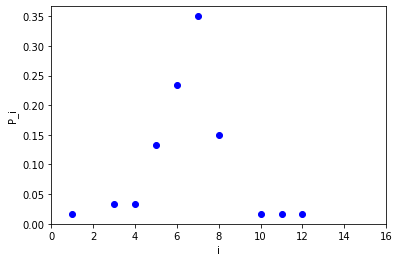

In [6]:
plt.plot(values,counts/N, 'b.', markersize=12)
plt.ylabel('P_i')
plt.xlabel('i')
plt.xlim(0,16)

In [7]:
def num_circuit(num, wires):
    bin_str = format(num, '#06b')[2:]
    for i, c in enumerate(bin_str):
        if c == '1':
            qml.PauliX(wires=i+wires[0])
    

In [8]:
@qml.qnode(dev)
def circuit(num):
    num_circuit(num, [0,1,2,3])
    return qml.expval(qml.PauliZ(0))

/tmp/ipykernel_453446/416124146.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


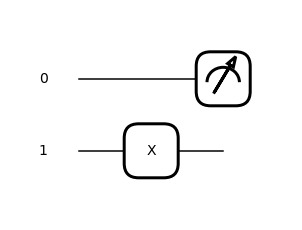

In [9]:
fig, ax = qml.draw_mpl(circuit)(4)
fig.show()

In [10]:
def G_anastz(params, qbits):
    qml.Hadamard(wires=qbits[0])
    qml.RY(params[0], wires=qbits[1])
    qml.RY(params[1], wires=qbits[2])
    qml.RY(params[2], wires=qbits[3])
    qml.CNOT(wires=[qbits[0],qbits[1]])
    qml.CNOT(wires=[qbits[0],qbits[2]])
    qml.CNOT(wires=[qbits[0],qbits[3]])

In [11]:
@qml.qnode(dev)
def circuit2(params, wires):
    G_anastz(params, wires)
    return qml.expval(qml.PauliZ(0))

/tmp/ipykernel_453446/1623408509.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


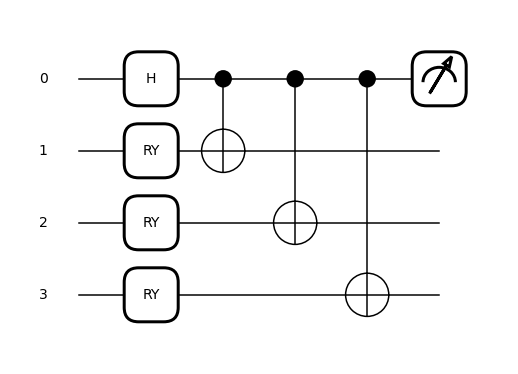

In [12]:
fig, ax = qml.draw_mpl(circuit2)([1,1,1], [0,1,2,3])
fig.show()

## normal swap

In [13]:
np.random.random(size=10)

tensor([0.39470342, 0.02556667, 0.95478827, 0.97854488, 0.56750642,
        0.72846237, 0.8733904 , 0.46486817, 0.94861578, 0.37033925], requires_grad=True)

In [14]:
@qml.qnode(dev)
def training_circ(data, paramsg, paramsd):
    # top 4 qbits real data
    num_circuit(data, [1,2,3,4])
    # bottom 4 qbits gen ansatz
    G_anastz(paramsg, [5,6,7,8])
    # parametrized swap test
    qml.Hadamard(wires=0)
    qml.CSWAP(wires=[0,1,5])
    qml.CSWAP(wires=[0,2,6])
    qml.CSWAP(wires=[0,3,7])
    qml.CSWAP(wires=[0,4,8])
    for i in range(1,9): qml.RZ(paramsd[i-1],wires=i)
    qml.Hadamard(wires=0)
    return qml.expval(qml.PauliZ(0))

/tmp/ipykernel_453446/1495549354.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


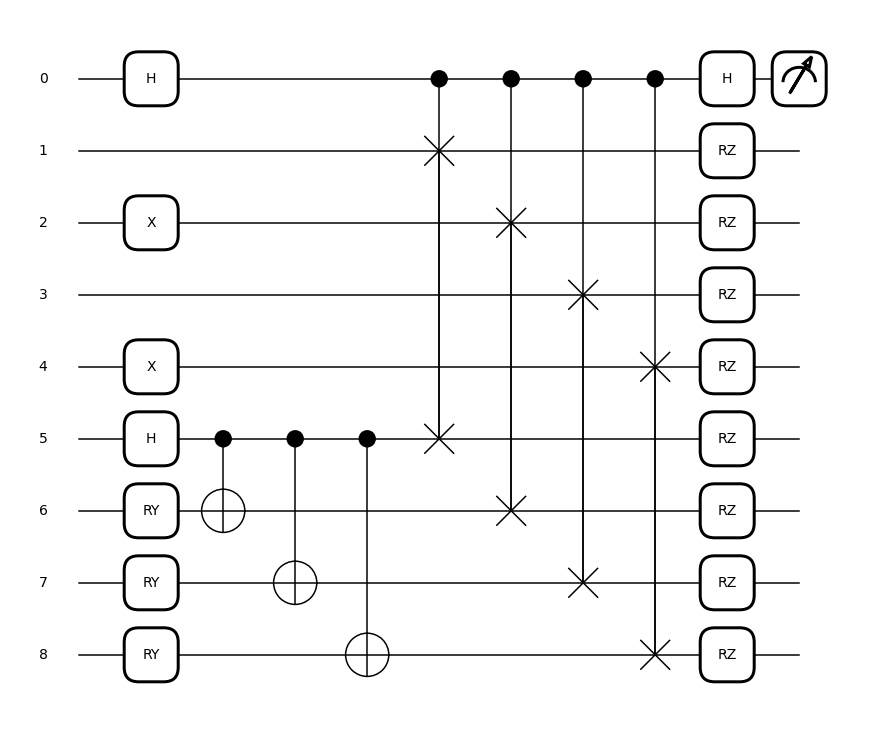

In [15]:
fig, ax = qml.draw_mpl(training_circ)(5, np.random.random(size=3), np.random.random(size=8))
fig.show()

## Training 

In [16]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]
        
def cost_batch(paramsg, paramsd, batch):
    loss = 0.0
    for i in batch:
        f = training_circ(i, paramsg, paramsd)
        loss = loss + (1 - f)
    return loss / len(batch)

In [17]:
paramsg = np.random.uniform(0,2*np.pi, size=3, requires_grad=True)
paramsd = np.random.uniform(0,2*np.pi, size=8, requires_grad=True)

In [18]:
epochs = 500
batch_size=16
learning_rate=0.01

In [19]:
optg = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
optd = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

In [20]:
print("initial paramsg:", paramsg)
print("initial paramsd:", paramsd)

paramsg_before = paramsg.copy()
paramsd_before = paramsd.copy()

start = time.time()

for it in range(epochs):
    start_b = time.time()
    for j,Xbatch in enumerate(iterate_minibatches(data, batch_size=batch_size)):  
        if it % 2 == 0:
            cost_fn = lambda p: -1*cost_batch(paramsg, p, Xbatch)
            paramsd = optd.step(cost_fn, paramsd)
        if it % 2 == 1:
            cost_fn = lambda p: cost_batch(p, paramsd, Xbatch)
            paramsg = optg.step(cost_fn, paramsg)
        print(j, end="\r")
        #if j % 20 == 0:
        #    loss = cost_batch(params,Xbatch)
        #    print(f"Step: {j} | Loss: {loss:.3} |")
    
    loss = cost_batch(paramsg, paramsd, data)
    
    print("____")
    print(f"Epoch: {it} | Loss: {loss:.3} | ")
    print("____")
    
end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

print("final paramsg:", paramsg)
print("final paramsd:", paramsd)

initial paramsg: [0.96250364 5.95080476 4.04414604]
initial paramsd: [2.05090508 4.86118777 3.39910067 5.88876472 2.00240237 4.0476473
 5.78845408 5.24836497]
____
Epoch: 0 | Loss: 0.979 | 
____
____
Epoch: 1 | Loss: 0.978 | 
____
____
Epoch: 2 | Loss: 0.978 | 
____
____
Epoch: 3 | Loss: 0.977 | 
____
____
Epoch: 4 | Loss: 0.977 | 
____
____
Epoch: 5 | Loss: 0.976 | 
____
____
Epoch: 6 | Loss: 0.976 | 
____
____
Epoch: 7 | Loss: 0.975 | 
____
____
Epoch: 8 | Loss: 0.975 | 
____
____
Epoch: 9 | Loss: 0.973 | 
____
____
Epoch: 10 | Loss: 0.973 | 
____
____
Epoch: 11 | Loss: 0.972 | 
____
____
Epoch: 12 | Loss: 0.972 | 
____
____
Epoch: 13 | Loss: 0.97 | 
____
____
Epoch: 14 | Loss: 0.97 | 
____
____
Epoch: 15 | Loss: 0.969 | 
____
____
Epoch: 16 | Loss: 0.969 | 
____
____
Epoch: 17 | Loss: 0.967 | 
____
____
Epoch: 18 | Loss: 0.967 | 
____
____
Epoch: 19 | Loss: 0.965 | 
____
____
Epoch: 20 | Loss: 0.965 | 
____
____
Epoch: 21 | Loss: 0.963 | 
____
____
Epoch: 22 | Loss: 0.963 | 
____
__

In [21]:
sample_dev = qml.device('lightning.qubit', wires=4, shots = N)
@qml.qnode(sample_dev)
def sample_test():
    G_anastz(paramsg, [0,1,2,3])
    return qml.sample()

In [22]:
testresult = [int(''.join(str(i) for i in a), 2) for a in sample_test()]

In [23]:
valuestest, countstest = np.unique(testresult, return_counts=True)

In [24]:
x=np.arange(0,16)
zerovals = [i for i in x if i not in valuestest]
zeros = np.zeros(len(zerovals))
valuestest = np.append(valuestest, zerovals)
countstest = np.append(countstest, zeros)

x=np.arange(0,16)
zerovals = [i for i in x if i not in values]
zeros = np.zeros(len(zerovals))
values = np.append(values, zerovals)
counts = np.append(counts, zeros)

(0.0, 16.0)

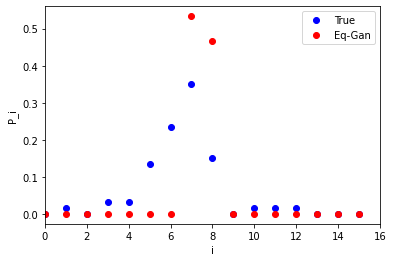

In [25]:
plt.plot(values,counts/N, 'b.', markersize=12, label="True")
plt.plot(valuestest,countstest/N, 'r.', markersize=12, label="Eq-Gan")
plt.ylabel('P_i')
plt.xlabel('i')
plt.legend()
plt.xlim(0,16)